## Importing libraries

In [1]:
# !pip install python-dotenv
import requests
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from dotenv import load_dotenv
import os
import zipfile
import shutil
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# Retrieving api key
load_dotenv("../key.env")
api_key = os.getenv("API_KEY")

## Reading datasets

In [2]:
#Running the get_bus_info function to make bus info related API calls
%run get_bus_info_function.ipynb

In [3]:
bus_services_df = get_bus_info("https://datamall2.mytransport.sg/ltaodataservice/BusServices", api_key)
bus_routes_df = get_bus_info("https://datamall2.mytransport.sg/ltaodataservice/BusRoutes", api_key)
bus_stops_df = get_bus_info("https://datamall2.mytransport.sg/ltaodataservice/BusStops", api_key)

In [4]:
bus_stop_example = bus_stops_df['BusStopCode'][0]
bus_arrival_df = get_bus_arrival("https://datamall2.mytransport.sg/ltaodataservice/v3/BusArrival", api_key, bus_stop_example)

In [5]:
bus_stops_df.head()

,BusStopCode,RoadName,Description,Latitude,Longitude
0,01012,Victoria St,Hotel Grand Pacific,1.296848,103.852536
1,01013,Victoria St,St. Joseph's Ch,1.297710,103.853225
2,01019,Victoria St,Bras Basah Cplx,1.296990,103.853022
3,01029,Nth Bridge Rd,Opp Natl Lib,1.296673,103.854414
4,01039,Nth Bridge Rd,Bugis Cube,1.298208,103.855491


In [6]:
bus_stop_pv_jul = pd.read_csv("../datasets/pv_bus_stops/transport_node_bus_202407.csv")
bus_stop_pv_aug = pd.read_csv("../datasets/pv_bus_stops/transport_node_bus_202408.csv")
bus_stop_pv_sep = pd.read_csv("../datasets/pv_bus_stops/transport_node_bus_202409.csv")

In [7]:
bus_stop_pv_jul.head()

,YEAR_MONTH,DAY_TYPE,TIME_PER_HOUR,PT_TYPE,PT_CODE,TOTAL_TAP_IN_VOLUME,TOTAL_TAP_OUT_VOLUME
0,2024-07,WEEKENDS/HOLIDAY,13.0,BUS,26041,2,0
1,2024-07,WEEKDAY,14.0,BUS,66261,73,19
2,2024-07,WEEKDAY,23.0,BUS,83011,91,565
3,2024-07,WEEKENDS/HOLIDAY,10.0,BUS,82079,353,687
4,2024-07,WEEKENDS/HOLIDAY,8.0,BUS,67239,390,171


In [8]:
bus_od_jul = pd.read_csv("../datasets/pv_od_bus_stops/origin_destination_bus_202407.csv")
bus_od_aug = pd.read_csv("../datasets/pv_od_bus_stops/origin_destination_bus_202408.csv")
bus_od_sep = pd.read_csv("../datasets/pv_od_bus_stops/origin_destination_bus_202409.csv")

In [9]:
trunk_buses_df = bus_services_df[bus_services_df['Category'] == "TRUNK"]
bus_routes_df = pd.merge(bus_routes_df, trunk_buses_df[['ServiceNo']], on='ServiceNo', how='inner')
bus_routes_simple = bus_routes_df[["ServiceNo", "Direction", "StopSequence", "BusStopCode"]]
bus_stops_simple = bus_stops_df[["BusStopCode", "RoadName", "Description"]]

bus_routes_stops = pd.merge(bus_routes_simple, bus_stops_simple, on="BusStopCode", how="inner")
bus_routes_stops.head()

,ServiceNo,Direction,StopSequence,BusStopCode,RoadName,Description
0,10,1,1,75009,Tampines Ctrl 1,Tampines Int
1,10,1,1,75009,Tampines Ctrl 1,Tampines Int
2,10,1,2,76059,Tampines Ave 5,Opp Our Tampines Hub
3,10,1,2,76059,Tampines Ave 5,Opp Our Tampines Hub
4,10,1,3,76069,Tampines Ave 5,Blk 147


In [10]:
train_station_pv_jul = pd.read_csv("../datasets/pv_train_stations/transport_node_train_202407.csv")
train_station_pv_aug = pd.read_csv("../datasets/pv_train_stations/transport_node_train_202408.csv")
train_station_pv_sep = pd.read_csv("../datasets/pv_train_stations/transport_node_train_202409.csv")

In [11]:
train_station_pv_jul['PT_CODE'] = train_station_pv_jul['PT_CODE'].str.split('/')
train_station_jul = train_station_pv_jul.explode('PT_CODE').reset_index(drop=True)
train_station_pv_aug['PT_CODE'] = train_station_pv_aug['PT_CODE'].str.split('/')
train_station_aug = train_station_pv_aug.explode('PT_CODE').reset_index(drop=True)
train_station_pv_sep['PT_CODE'] = train_station_pv_sep['PT_CODE'].str.split('/')
train_station_sep = train_station_pv_sep.explode('PT_CODE').reset_index(drop=True)
train_station_sep.head()

,YEAR_MONTH,DAY_TYPE,TIME_PER_HOUR,PT_TYPE,PT_CODE,TOTAL_TAP_IN_VOLUME,TOTAL_TAP_OUT_VOLUME
0,2024-09,WEEKDAY,20,TRAIN,NE4,84956,36786
1,2024-09,WEEKDAY,20,TRAIN,DT19,84956,36786
2,2024-09,WEEKDAY,14,TRAIN,TE28,3495,3602
3,2024-09,WEEKDAY,17,TRAIN,NE10,30759,24075
4,2024-09,WEEKDAY,22,TRAIN,NS23,44671,9804


## EDA of Bus Routes and Services

### 1a. Trend of Passenger Volume by Bus Route
- Assumption: Passenger Volumes represented by Total Number of Tap Ins and Tap Outs
- Things to note: There are multiple buses services at the same bus stops, the passenger volume is computed by total tap volumes of bus stops along the bus routes

#### Feature extraction for change in passenger volume by Bus Service Routes

##### 1a1. Aggregating the passenger volume of Interchange and Mrt Station Exit Bus Stops only

In [12]:
#Joining description of bus stop with bus stops passenger volume
bus_stop_pv_jul['PT_CODE'] = bus_stop_pv_jul['PT_CODE'].astype(str)
bus_stop_pv_aug['PT_CODE'] = bus_stop_pv_aug['PT_CODE'].astype(str)
bus_stop_pv_sep['PT_CODE'] = bus_stop_pv_sep['PT_CODE'].astype(str)

bus_stop_pv_jul =  pd.merge(bus_stop_pv_jul, bus_stops_df[['BusStopCode', 'Description']],
                     left_on = 'PT_CODE',right_on='BusStopCode', how='left')
bus_stop_pv_aug =  pd.merge(bus_stop_pv_aug, bus_stops_df[['BusStopCode', 'Description']],
                     left_on = 'PT_CODE',right_on='BusStopCode', how='left')
bus_stop_pv_sep =  pd.merge(bus_stop_pv_sep, bus_stops_df[['BusStopCode', 'Description']],
                     left_on = 'PT_CODE',right_on='BusStopCode', how='left')

In [13]:
bus_stop_pv_sep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199900 entries, 0 to 199899
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   YEAR_MONTH            199900 non-null  object 
 1   DAY_TYPE              199900 non-null  object 
 2   TIME_PER_HOUR         199823 non-null  float64
 3   PT_TYPE               199900 non-null  object 
 4   PT_CODE               199900 non-null  object 
 5   TOTAL_TAP_IN_VOLUME   199900 non-null  int64  
 6   TOTAL_TAP_OUT_VOLUME  199900 non-null  int64  
 7   BusStopCode           190898 non-null  object 
 8   Description           190898 non-null  object 
dtypes: float64(1), int64(2), object(6)
memory usage: 13.7+ MB


In [14]:
# Filter bus stops whose descriptions contain either 'Int' or 'Stn'
filtered_bus_stops_jul = bus_stop_pv_jul[bus_stop_pv_jul['Description'].str.contains(r'\b(Int|Stn)(\b|[\s/])', case=False, na=False)]
filtered_bus_stops_aug = bus_stop_pv_aug[bus_stop_pv_aug['Description'].str.contains(r'\b(Int|Stn)(\b|[\s/])', case=False, na=False)]
filtered_bus_stops_sep = bus_stop_pv_sep[bus_stop_pv_sep['Description'].str.contains(r'\b(Int|Stn)(\b|[\s/])', case=False, na=False)]

# Aggregate the total tap volume for each bus stop for each month
bus_stop_pv_jul_agg_filtered = filtered_bus_stops_jul.groupby('PT_CODE').agg(
    JulyTapIn=('TOTAL_TAP_IN_VOLUME', 'sum'),
    JulyTapOut=('TOTAL_TAP_OUT_VOLUME', 'sum')
).reset_index()

bus_stop_pv_aug_agg_filtered = filtered_bus_stops_aug.groupby('PT_CODE').agg(
    AugTapIn=('TOTAL_TAP_IN_VOLUME', 'sum'),
    AugTapOut=('TOTAL_TAP_OUT_VOLUME', 'sum')
).reset_index()

bus_stop_pv_sep_agg_filtered = filtered_bus_stops_sep.groupby('PT_CODE').agg(
    SepTapIn=('TOTAL_TAP_IN_VOLUME', 'sum'),
    SepTapOut=('TOTAL_TAP_OUT_VOLUME', 'sum')
).reset_index()

# Merge aggregated bus stop data for each month with bus routes
route_passenger_volumes_jul_ft = pd.merge(bus_routes_df, bus_stop_pv_jul_agg_filtered, 
                                       left_on='BusStopCode', right_on='PT_CODE', how='left').fillna(0)

route_passenger_volumes_aug_ft = pd.merge(bus_routes_df, bus_stop_pv_aug_agg_filtered, 
                                       left_on='BusStopCode', right_on='PT_CODE', how='left').fillna(0)

route_passenger_volumes_sep_ft = pd.merge(bus_routes_df, bus_stop_pv_sep_agg_filtered, 
                                       left_on='BusStopCode', right_on='PT_CODE', how='left').fillna(0)
# Aggregate total passenger volume per service route for each month
route_pv_jul_ft = route_passenger_volumes_jul_ft.groupby('ServiceNo').agg(
    JulyTotalTapIn=('JulyTapIn', 'sum'),
    JulyTotalTapOut=('JulyTapOut', 'sum')
).reset_index()

route_pv_aug_ft = route_passenger_volumes_aug_ft.groupby('ServiceNo').agg(
    AugTotalTapIn=('AugTapIn', 'sum'),
    AugTotalTapOut=('AugTapOut', 'sum')
).reset_index()

route_pv_sep_ft = route_passenger_volumes_sep_ft.groupby('ServiceNo').agg(
    SepTotalTapIn=('SepTapIn', 'sum'),
    SepTotalTapOut=('SepTapOut', 'sum')
).reset_index()
# Merge passenger volumes of each month for each bus service route
route_pv_combined_ft = route_pv_jul_ft.merge(route_pv_aug_ft, on='ServiceNo', how='outer')\
                                .merge(route_pv_sep_ft, on='ServiceNo', how='outer').fillna(0)

# Calculate total tap volume for each month
route_pv_combined_ft['JulyTotalVolume'] = route_pv_combined_ft['JulyTotalTapIn'] + route_pv_combined_ft['JulyTotalTapOut']
route_pv_combined_ft['AugTotalVolume'] = route_pv_combined_ft['AugTotalTapIn'] + route_pv_combined_ft['AugTotalTapOut']
route_pv_combined_ft['SepTotalVolume'] = route_pv_combined_ft['SepTotalTapIn'] + route_pv_combined_ft['SepTotalTapOut']

# calculate the absolute change
route_pv_combined_ft['VolumeDecrease_Jul_to_Sep'] = route_pv_combined_ft['JulyTotalVolume'] - route_pv_combined_ft['SepTotalVolume']



C:\Users\Gene\AppData\Local\Temp\ipykernel_12160\3898714737.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  filtered_bus_stops_jul = bus_stop_pv_jul[bus_stop_pv_jul['Description'].str.contains(r'\b(Int|Stn)(\b|[\s/])', case=False, na=False)]
C:\Users\Gene\AppData\Local\Temp\ipykernel_12160\3898714737.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  filtered_bus_stops_aug = bus_stop_pv_aug[bus_stop_pv_aug['Description'].str.contains(r'\b(Int|Stn)(\b|[\s/])', case=False, na=False)]
C:\Users\Gene\AppData\Local\Temp\ipykernel_12160\3898714737.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  filtered_bus_stops_sep = bus_stop_pv_sep[bus_stop_pv_sep['Description'].str.contains(r'\b(Int|Stn)(\b|[\s/])', case=False, na=Fal

In [15]:
# Min-Max normalize VolumeDecrease_Jul_to_Sep
scaler = MinMaxScaler()
route_pv_combined_ft['NormalizedVolumeDecrease'] = scaler.fit_transform(route_pv_combined_ft[['VolumeDecrease_Jul_to_Sep']])

# Apply softmax to penalize more on routes with a higher decrease
max_normalized = route_pv_combined_ft['NormalizedVolumeDecrease'].max()
route_pv_combined_ft['SoftmaxVolumeDecrease'] = np.exp(route_pv_combined_ft['NormalizedVolumeDecrease'] - max_normalized) / \
                                             np.sum(np.exp(route_pv_combined_ft['NormalizedVolumeDecrease'] - max_normalized))
route_pv_combined_ft.to_csv('../datasets/pv_eda/routes_pv_combined_ft.csv', index=False)
print(route_pv_combined_ft.head())

  ServiceNo  JulyTotalTapIn  JulyTotalTapOut  AugTotalTapIn  AugTotalTapOut  \
0        10       7049374.0        7175786.0      7055912.0       7159482.0   
1       100       4141270.0        3468648.0      4086074.0       3401896.0   
2      100A        568184.0         415368.0       561357.0        403512.0   
3       101       1312721.0        1066462.0      1289887.0       1039356.0   
4       102       1617768.0        1540139.0      1567590.0       1501491.0   

   SepTotalTapIn  SepTotalTapOut  JulyTotalVolume  AugTotalVolume  \
0      6629624.0       6719422.0       14225160.0      14215394.0   
1      3979716.0       3317702.0        7609918.0       7487970.0   
2       547548.0        392128.0         983552.0        964869.0   
3      1237287.0        998823.0        2379183.0       2329243.0   
4      1488984.0       1428866.0        3157907.0       3069081.0   

   SepTotalVolume  VolumeDecrease_Jul_to_Sep  NormalizedVolumeDecrease  \
0      13349046.0                   

##### 1a2. Aggregating the passenger volume of all bus stops

In [16]:
# Convert 'BusStopCode' and 'BusStop' to string
bus_routes_df['BusStopCode'] = bus_routes_df['BusStopCode'].astype(str)

# Aggregate the total tap volume for each bus stop for each month
bus_stop_pv_jul_agg = bus_stop_pv_jul.groupby('PT_CODE').agg(
    JulyTapIn=('TOTAL_TAP_IN_VOLUME', 'sum'),
    JulyTapOut=('TOTAL_TAP_OUT_VOLUME', 'sum')
).reset_index()

bus_stop_pv_aug_agg = bus_stop_pv_aug.groupby('PT_CODE').agg(
    AugTapIn=('TOTAL_TAP_IN_VOLUME', 'sum'),
    AugTapOut=('TOTAL_TAP_OUT_VOLUME', 'sum')
).reset_index()

bus_stop_pv_sep_agg = bus_stop_pv_sep.groupby('PT_CODE').agg(
    SepTapIn=('TOTAL_TAP_IN_VOLUME', 'sum'),
    SepTapOut=('TOTAL_TAP_OUT_VOLUME', 'sum')
).reset_index()

# Merge aggregated bus stop data for each month with bus routes
route_passenger_volumes_jul = pd.merge(bus_routes_df, bus_stop_pv_jul_agg, 
                                       left_on='BusStopCode', right_on='PT_CODE', how='left').fillna(0)

route_passenger_volumes_aug = pd.merge(bus_routes_df, bus_stop_pv_aug_agg, 
                                       left_on='BusStopCode', right_on='PT_CODE', how='left').fillna(0)

route_passenger_volumes_sep = pd.merge(bus_routes_df, bus_stop_pv_sep_agg, 
                                       left_on='BusStopCode', right_on='PT_CODE', how='left').fillna(0)
# Aggregate total passenger volume per service route for each month
route_pv_jul = route_passenger_volumes_jul.groupby('ServiceNo').agg(
    JulyTotalTapIn=('JulyTapIn', 'sum'),
    JulyTotalTapOut=('JulyTapOut', 'sum')
).reset_index()

route_pv_aug = route_passenger_volumes_aug.groupby('ServiceNo').agg(
    AugTotalTapIn=('AugTapIn', 'sum'),
    AugTotalTapOut=('AugTapOut', 'sum')
).reset_index()

route_pv_sep = route_passenger_volumes_sep.groupby('ServiceNo').agg(
    SepTotalTapIn=('SepTapIn', 'sum'),
    SepTotalTapOut=('SepTapOut', 'sum')
).reset_index()
# Merge passenger volumes of each month for each bus service route
route_pv_combined = route_pv_jul.merge(route_pv_aug, on='ServiceNo', how='outer')\
                                .merge(route_pv_sep, on='ServiceNo', how='outer').fillna(0)

# Calculate total tap volume for each month
route_pv_combined['JulyTotalVolume'] = route_pv_combined['JulyTotalTapIn'] + route_pv_combined['JulyTotalTapOut']
route_pv_combined['AugTotalVolume'] = route_pv_combined['AugTotalTapIn'] + route_pv_combined['AugTotalTapOut']
route_pv_combined['SepTotalVolume'] = route_pv_combined['SepTotalTapIn'] + route_pv_combined['SepTotalTapOut']

# calculate the absolute change
route_pv_combined['VolumeDecrease_Jul_to_Sep'] = route_pv_combined['JulyTotalVolume'] - route_pv_combined['SepTotalVolume']


In [17]:
# Min-Max normalize VolumeDecrease_Jul_to_Sep
scaler = MinMaxScaler()
route_pv_combined['NormalizedVolumeDecrease'] = scaler.fit_transform(route_pv_combined[['VolumeDecrease_Jul_to_Sep']])

# Apply softmax to penalize more on routes with a higher decrease
max_normalized = route_pv_combined['NormalizedVolumeDecrease'].max()
route_pv_combined['SoftmaxVolumeDecrease'] = np.exp(route_pv_combined['NormalizedVolumeDecrease'] - max_normalized) / \
                                             np.sum(np.exp(route_pv_combined['NormalizedVolumeDecrease'] - max_normalized))
route_pv_combined.to_csv('../datasets/pv_eda/routes_pv_combined.csv', index=False)
print(route_pv_combined.head())

  ServiceNo  JulyTotalTapIn  JulyTotalTapOut  AugTotalTapIn  AugTotalTapOut  \
0        10      11429188.0       11414196.0     11537526.0      11515306.0   
1       100       8261938.0        7251470.0      8202912.0       7191772.0   
2      100A        793685.0         665085.0       786062.0        648710.0   
3       101       2209738.0        1994069.0      2169520.0       1949728.0   
4       102       2789379.0        2671010.0      2708154.0       2596816.0   

   SepTotalTapIn  SepTotalTapOut  JulyTotalVolume  AugTotalVolume  \
0     10801766.0      10761844.0       22843384.0      23052832.0   
1      7991198.0       7000132.0       15513408.0      15394684.0   
2       762100.0        628070.0        1458770.0       1434772.0   
3      2062335.0       1856088.0        4203807.0       4119248.0   
4      2564411.0       2460953.0        5460389.0       5304970.0   

   SepTotalVolume  VolumeDecrease_Jul_to_Sep  NormalizedVolumeDecrease  \
0      21563610.0                  1

In [18]:
route_pv_combined.shape

(401, 13)

#### Routes with decreasing passenger colume from July - September 2024

In [19]:
# Convert 'BusStopCode' and 'BusStop' to string
bus_routes_stops['BusStopCode'] = bus_routes_stops['BusStopCode'].astype(str)
bus_stop_pv_jul['PT_CODE'] = bus_stop_pv_jul['PT_CODE'].astype(str)
bus_stop_pv_aug['PT_CODE'] = bus_stop_pv_aug['PT_CODE'].astype(str)
bus_stop_pv_sep['PT_CODE'] = bus_stop_pv_sep['PT_CODE'].astype(str)

# Merge bus_routes with bus_stops_passenger_volume to get passenger volumes per route
route_passenger_volumes = pd.merge(bus_routes_stops, bus_stop_pv_jul, 
                                   left_on='BusStopCode', right_on="PT_CODE", how='left')
route_passenger_volumes_aug = pd.merge(bus_routes_stops, bus_stop_pv_aug, 
                                       left_on='BusStopCode', right_on="PT_CODE", how='left')
route_passenger_volumes_sep = pd.merge(bus_routes_stops, bus_stop_pv_sep, 
                                       left_on='BusStopCode', right_on="PT_CODE", how='left')

# Group by 'ServiceNo' and 'YEAR_MONTH' to get the total tap-in and tap-out volumes for each service in each month
monthly_passenger_volume_jul = route_passenger_volumes.groupby(['ServiceNo', 'YEAR_MONTH'])[['TOTAL_TAP_IN_VOLUME', 'TOTAL_TAP_OUT_VOLUME']].sum().reset_index()
monthly_passenger_volume_aug = route_passenger_volumes_aug.groupby(['ServiceNo', 'YEAR_MONTH'])[['TOTAL_TAP_IN_VOLUME', 'TOTAL_TAP_OUT_VOLUME']].sum().reset_index()
monthly_passenger_volume_sep = route_passenger_volumes_sep.groupby(['ServiceNo', 'YEAR_MONTH'])[['TOTAL_TAP_IN_VOLUME', 'TOTAL_TAP_OUT_VOLUME']].sum().reset_index()

In [20]:
monthly_passenger_volume_jul['ServiceNo'].unique().shape

(400,)

In [21]:
# Concatenate all three months' data
all_months_data = pd.concat([monthly_passenger_volume_jul, 
                             monthly_passenger_volume_aug,
                             monthly_passenger_volume_sep])

# Reset index after concatenation
all_months_data.reset_index(drop=True, inplace=True)

# Create a new column 'TOTAL_TAP_VOLUME'
all_months_data['TOTAL_TAP_VOLUME'] = all_months_data['TOTAL_TAP_IN_VOLUME'] + all_months_data['TOTAL_TAP_OUT_VOLUME']

In [22]:
all_months_data['ServiceNo'].shape

(1200,)

In [23]:
# Pivot the data to have 'ServiceNo' as rows and 'YEAR_MONTH' as columns
tap_in_pivot = all_months_data.pivot(index='ServiceNo', columns='YEAR_MONTH', values='TOTAL_TAP_VOLUME')

# Preview the pivot table
tap_in_pivot.head()

# Check the trend: assign "Decreasing" if volumes are consistently going down, otherwise "Increasing"
tap_in_pivot['Trend'] = tap_in_pivot.apply(
    lambda row: 'Decreasing' if (row['2024-07'] > row['2024-08']) and (row['2024-08'] > row['2024-09']) 
                else 'Increasing', 
    axis=1
)

# Create a DataFrame for routes with the trend information
trend_routes_df = tap_in_pivot.reset_index()

# Optional: Convert "Trend" column to binary values (1 for "Increasing", 0 for "Decreasing")
trend_routes_df['Trend_Binary'] = trend_routes_df['Trend'].map({'Increasing': 1, 'Decreasing': 0})

In [24]:
# Calculate the decrease from '2024-07' to '2024-09'
trend_routes_df['Change'] = trend_routes_df['2024-09'] - trend_routes_df['2024-07']
# Calculate the average from '2024-07' to '2024-09'
trend_routes_df['Average'] = trend_routes_df[['2024-07', '2024-08', '2024-09']].mean(axis=1)
print(trend_routes_df.head())
trend_routes_df.to_csv('../datasets/pv_eda/routes_pv_trend.csv', index=False)

YEAR_MONTH ServiceNo     2024-07     2024-08     2024-09       Trend  \
0                 10  22843384.0  23052832.0  21563610.0  Increasing   
1                100  15513408.0  15394684.0  14991330.0  Decreasing   
2               100A   1458770.0   1434772.0   1390170.0  Decreasing   
3                101   4203807.0   4119248.0   3918423.0  Decreasing   
4                102   5460389.0   5304970.0   5025364.0  Decreasing   

YEAR_MONTH  Trend_Binary     Change       Average  
0                      1 -1279774.0  2.248661e+07  
1                      0  -522078.0  1.529981e+07  
2                      0   -68600.0  1.427904e+06  
3                      0  -285384.0  4.080493e+06  
4                      0  -435025.0  5.263574e+06  


In [26]:
trend_routes_decreasing = trend_routes_df[trend_routes_df['Trend']=='Decreasing']

In [30]:
trend_routes_decreasing = trend_routes_decreasing.sort_values(by = "Change", ascending = True)

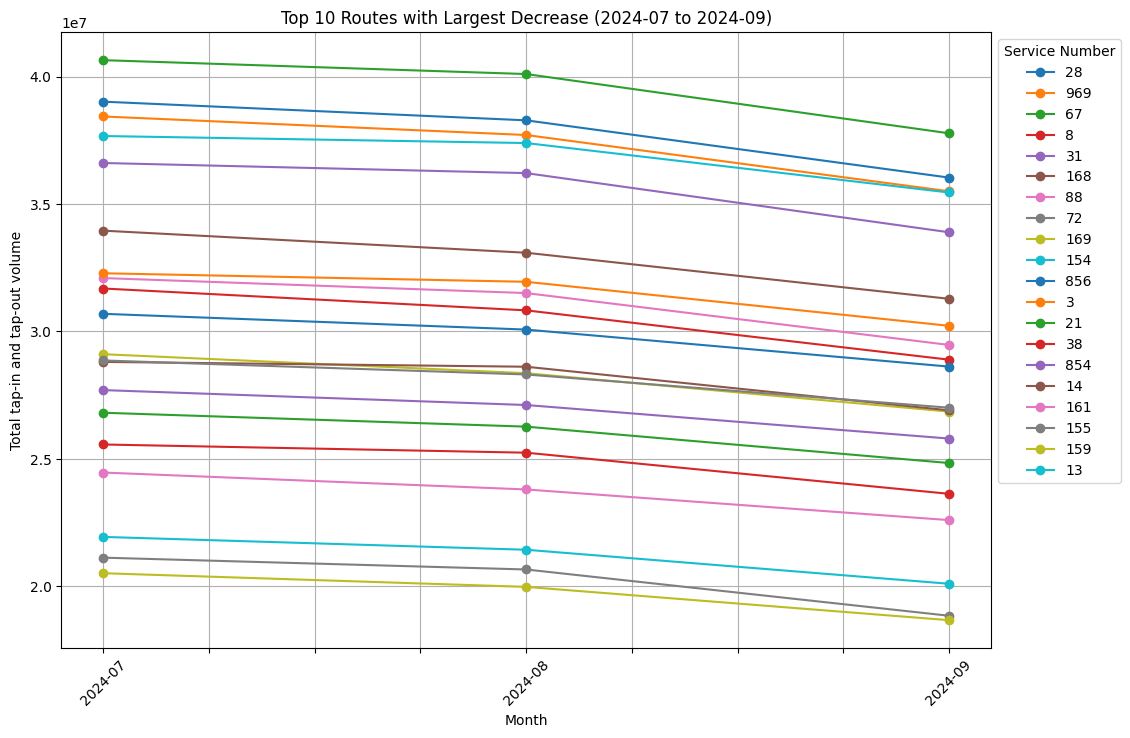

In [33]:
# Select the top 10 routes with the largest decrease
top_10_decreasing_routes = trend_routes_decreasing.head(20)

# Extract the tap-in data for the selected routes using .loc
tap_in = tap_in_pivot.loc[top_10_decreasing_routes['ServiceNo'], ['2024-07', '2024-08', '2024-09']]

# Reset index to make 'ServiceNo' a column
tap_in.reset_index(inplace=True)

# Plot the line graph
plt.figure(figsize=(12, 8))

# Plotting directly without iterating
tap_in.set_index('ServiceNo').T.plot(marker='o', ax=plt.gca())

plt.title('Top 10 Routes with Largest Decrease (2024-07 to 2024-09)')
plt.xlabel('Month')
plt.ylabel('Total tap-in and tap-out volume')
plt.xticks(rotation=45)
plt.legend(title='Service Number', bbox_to_anchor=(1, 1), loc='upper left')
plt.grid()
plt.show()

In [ ]:
decreasing_routes_df.head()

YEAR_MONTH,ServiceNo,2024-07,2024-08,2024-09,Decreasing,Decrease,Average
0,100,15513408.0,15394684.0,14991330.0,True,522078.0,1.529981e+07
1,100A,1458770.0,1434772.0,1390170.0,True,68600.0,1.427904e+06
2,101,4203807.0,4119248.0,3918423.0,True,285384.0,4.080493e+06
3,102,5460389.0,5304970.0,5025364.0,True,435025.0,5.263574e+06
4,102A,842857.0,818805.0,776782.0,True,66075.0,8.128147e+05


### 1b. Normalise Passenger Volumes of Bus Routes by Total Number of Bus Stops

In [ ]:
# Group by 'bus_service_no' and count the total number of stops it serves 'stop_sequence' for each bus service
route_stop_count = bus_routes_df.groupby('ServiceNo')['StopSequence'].count().reset_index()

# Rename the columns for clarity
route_stop_count.columns = ['ServiceNo', 'TotalStops']

# Normalise the dataset
normalised_bus_services_df = pd.merge(decreasing_routes_df, route_stop_count, 
                                   on = "ServiceNo", how = "left")

In [ ]:
normalised_bus_services_df['ServiceNo'].shape

(331,)

In [ ]:
# Select the relevant columns
features = ['Decrease', 'Average', 'TotalStops']

# Initialize the scaler
scaler = StandardScaler()
# Scale the features
normalised_bus_services_df[features] = scaler.fit_transform(normalised_bus_services_df[features])

# Initialize PCA to capture all three components
pca = PCA(n_components=3)  # Number of components equals number of original features
pca.fit(normalised_bus_services_df[features])

# Transform the data to get principal components
pca_components = pca.transform(normalised_bus_services_df[features])

# Extract and display the component loadings
loadings = pca.components_
feature_names = features
for i, component in enumerate(loadings):
    print(f"Principal Component {i+1}:")
    for feature, loading in zip(feature_names, component):
        print(f"   {feature}: {loading:.2f}")

# Variance explained by each principal component
explained_variance = pca.explained_variance_ratio_
for i, variance in enumerate(explained_variance):
    print(f"Principal Component {i+1} explains {variance:.2%} of the variance")

Principal Component 1:
   Decrease: 0.58
   Average: 0.60
   TotalStops: 0.55
Principal Component 2:
   Decrease: -0.55
   Average: -0.21
   TotalStops: 0.81
Principal Component 3:
   Decrease: -0.60
   Average: 0.77
   TotalStops: -0.21
Principal Component 1 explains 89.66% of the variance
Principal Component 2 explains 9.30% of the variance
Principal Component 3 explains 1.04% of the variance


In [ ]:
# Calculate weights by normalizing component loadings
total_loading = abs(0.58) + abs(0.60) + abs(0.55)
weights = {
    'Decrease': abs(0.58) / total_loading,
    'Average': abs(0.60) / total_loading,
    'TotalStops': abs(0.55) / total_loading
}

# Calculate Normalised score as a weighted sum
normalised_bus_services_df['Normalised'] = (
    weights['Decrease'] * normalised_bus_services_df['Decrease'] +
    weights['Average'] * normalised_bus_services_df['Average'] +
    weights['TotalStops'] * normalised_bus_services_df['TotalStops']
)


bus_routes_pv_softmax = normalised_bus_services_df.copy()

# Min-max scale Normalised column to range between 0 and 10
scaler = MinMaxScaler(feature_range=(0, 10))
bus_routes_pv_softmax['Scaled_Normalised'] = scaler.fit_transform(bus_routes_pv_softmax[['Normalised']])

# Apply softmax on the scaled values
max_scaled = bus_routes_pv_softmax['Scaled_Normalised'].max()
bus_routes_pv_softmax['Softmax'] = np.exp(bus_routes_pv_softmax['Scaled_Normalised'] - max_scaled) / np.sum(np.exp(bus_routes_pv_softmax['Scaled_Normalised'] - max_scaled))

# Sort the DataFrame by 'Normalised' in descending order
decreasing_normalised_bus_services_df_sorted = bus_routes_pv_softmax.sort_values(by='Softmax', ascending=False)
decreasing_normalised_bus_services_df_sorted.to_csv('../datasets/pv_eda/routes_w_normalised_pv.csv', index=False)

### 2a. Trend of Passenger Volumes by Bus Stops
- Assumption: Passenger Volumes represented by Total Number of Tap Ins and Tap Outs

In [ ]:
# Create a new column 'TOTAL_TAP_VOLUME' summing tap-in and tap-out volumes
bus_stop_pv_jul['TOTAL_TAP_VOLUME'] = bus_stop_pv_jul['TOTAL_TAP_IN_VOLUME'] + bus_stop_pv_jul['TOTAL_TAP_OUT_VOLUME']
bus_stop_pv_aug['TOTAL_TAP_VOLUME'] = bus_stop_pv_aug['TOTAL_TAP_IN_VOLUME'] + bus_stop_pv_aug['TOTAL_TAP_OUT_VOLUME']
bus_stop_pv_sep['TOTAL_TAP_VOLUME'] = bus_stop_pv_sep['TOTAL_TAP_IN_VOLUME'] + bus_stop_pv_sep['TOTAL_TAP_OUT_VOLUME']

# Group by PT_CODE and YEAR_MONTH to get total taps for each bus stop per month
monthly_tap_jul = bus_stop_pv_jul.groupby(['PT_CODE', 'YEAR_MONTH'])[['TOTAL_TAP_VOLUME']].sum().reset_index()
monthly_tap_aug = bus_stop_pv_aug.groupby(['PT_CODE', 'YEAR_MONTH'])[['TOTAL_TAP_VOLUME']].sum().reset_index()
monthly_tap_sep = bus_stop_pv_sep.groupby(['PT_CODE', 'YEAR_MONTH'])[['TOTAL_TAP_VOLUME']].sum().reset_index()

In [ ]:
# Concatenate all three months' data
all_months_taps = pd.concat([monthly_tap_jul, 
                             monthly_tap_aug,
                             monthly_tap_sep])

# Reset index after concatenation
all_months_taps.reset_index(drop=True, inplace=True)

In [ ]:
# Ensure 'PT_CODE' and 'BusStopCode' are of the same data type
all_months_taps['PT_CODE'] = all_months_taps['PT_CODE'].astype(str)

# Pivot the data to have 'ServiceNo' as rows and 'YEAR_MONTH' as columns
tap_bus_stop_pivot = all_months_taps.pivot(index='PT_CODE', columns='YEAR_MONTH', values='TOTAL_TAP_VOLUME')

# Preview the pivot table
tap_bus_stop_pivot.head()

# Assuming tap_in_pivot already has the data for '2024-07', '2024-08', and '2024-09'
tap_bus_stop_pivot['Decreasing'] = (tap_bus_stop_pivot['2024-07'] > tap_bus_stop_pivot['2024-08']) & (tap_bus_stop_pivot['2024-08'] > tap_bus_stop_pivot['2024-09'])

# Create a DataFrame for routes with decreasing tap-ins
taps_bus_stop_df = tap_bus_stop_pivot[tap_bus_stop_pivot['Decreasing']].reset_index()
taps_bus_stop_df.rename(columns={'YEAR_MONTH': 'Index'}, inplace=True)

# Ensure that 'bus_routes_stops_cleaned' has unique 'BusStopCode'
bus_routes_stops_cleaned = bus_routes_stops.drop_duplicates(subset=['BusStopCode'])

# Merge to get the name and description for both the ORIGIN and DESTINATION in July
decreasing_bus_stops_df = pd.merge(
    taps_bus_stop_df, 
    bus_routes_stops_cleaned[['BusStopCode', 'RoadName', 'Description']],
    left_on='PT_CODE', 
    right_on='BusStopCode', 
    how='left'
).drop(columns=['BusStopCode'])

In [ ]:
# Calculate the decrease from '2024-07' to '2024-09'
decreasing_bus_stops_df['Decrease'] = decreasing_bus_stops_df['2024-07'] - decreasing_bus_stops_df['2024-09']

# Sort the DataFrame by 'Decrease' in descending order
decreasing_bus_stops_df_sorted = decreasing_bus_stops_df.sort_values(by='Decrease', ascending=False)
decreasing_bus_stops_df_sorted.to_csv('../datasets/pv_eda/bus_stops_w_decreasing_pv.csv', index=False)

### 2b. Normalise Passenger Volumes of Bus Stops by Unique Number of Bus Services

In [ ]:
# Group by 'bus_stop_code' and count the unique 'bus_service' for each stop
bus_service_count = bus_routes_df.groupby('BusStopCode')['ServiceNo'].nunique().reset_index()

# Rename the columns for clarity
bus_service_count.columns = ['BusStopCode', 'TotalBusService']

In [ ]:
# Normalise the dataset
normalised_bus_stops_df = pd.merge(decreasing_bus_stops_df, bus_service_count, 
                                   left_on = "PT_CODE", right_on = "BusStopCode",
                                   how = "left").drop(columns=['BusStopCode'])
normalised_bus_stops_df['Normalised'] = normalised_bus_stops_df['Decrease'] / normalised_bus_stops_df['TotalBusService']

# Sort the DataFrame by 'Normalised' in descending order
decreasing_normalised_bus_stops_df_sorted = normalised_bus_stops_df.sort_values(by='Normalised', ascending=False)
decreasing_normalised_bus_stops_df_sorted.to_csv('../datasets/pv_eda/bus_stops_w_normalised_pv.csv', index=False)

### 3. Average (Mean and Median) Monthly Bus Servicing the Same Origin and Destination Routes

In [ ]:
# Convert both 'ORIGIN_PT_CODE' and 'DESTINATION_PT_CODE' columns to string for July
bus_od_jul[['ORIGIN_PT_CODE', 'DESTINATION_PT_CODE']] = bus_od_jul[['ORIGIN_PT_CODE', 'DESTINATION_PT_CODE']].astype(str)
bus_od_aug[['ORIGIN_PT_CODE', 'DESTINATION_PT_CODE']] = bus_od_aug[['ORIGIN_PT_CODE', 'DESTINATION_PT_CODE']].astype(str)
bus_od_sep[['ORIGIN_PT_CODE', 'DESTINATION_PT_CODE']] = bus_od_sep[['ORIGIN_PT_CODE', 'DESTINATION_PT_CODE']].astype(str)

# Group by 'YEAR_MONTH', 'ORIGIN_PT_CODE' and 'DESTINATION_PT_CODE'
grouped_trips_jul = bus_od_jul.groupby(['YEAR_MONTH', 'ORIGIN_PT_CODE', 'DESTINATION_PT_CODE'])[['TOTAL_TRIPS']].sum().reset_index()
grouped_trips_aug = bus_od_aug.groupby(['YEAR_MONTH', 'ORIGIN_PT_CODE', 'DESTINATION_PT_CODE'])[['TOTAL_TRIPS']].sum().reset_index()
grouped_trips_sep = bus_od_sep.groupby(['YEAR_MONTH', 'ORIGIN_PT_CODE', 'DESTINATION_PT_CODE'])[['TOTAL_TRIPS']].sum().reset_index()

In [ ]:
bus_od_jul.head()

,YEAR_MONTH,DAY_TYPE,TIME_PER_HOUR,PT_TYPE,ORIGIN_PT_CODE,DESTINATION_PT_CODE,TOTAL_TRIPS
0,2024-07,WEEKDAY,22,BUS,43499,43481,1
1,2024-07,WEEKENDS/HOLIDAY,23,BUS,22009,14109,1
2,2024-07,WEEKDAY,22,BUS,10099,3031,1
3,2024-07,WEEKENDS/HOLIDAY,16,BUS,7419,7031,33
4,2024-07,WEEKDAY,9,BUS,72079,60089,4


In [ ]:
# Ensure that 'bus_routes_stops_cleaned' has unique 'BusStopCode'
bus_routes_stops_cleaned = bus_routes_stops.drop_duplicates(subset=['BusStopCode'])

# Merge to get the name and description for both the ORIGIN and DESTINATION in July
route_trips_jul = pd.merge(
    grouped_trips_jul, 
    bus_routes_stops_cleaned[['BusStopCode', 'Description']].rename(columns={'Description': 'ORIGIN_DESCRIPTION'}),
    left_on='ORIGIN_PT_CODE', 
    right_on='BusStopCode', 
    how='left'
).drop(columns=['BusStopCode'])

route_trips_jul = pd.merge(
    route_trips_jul, 
    bus_routes_stops_cleaned[['BusStopCode', 'Description']].rename(columns={'Description': 'DESTINATION_DESCRIPTION'}),
    left_on='DESTINATION_PT_CODE', 
    right_on='BusStopCode', 
    how='left'
).drop(columns=['BusStopCode'])

# Merge to get the name and description for both the ORIGIN and DESTINATION in July
route_trips_aug = pd.merge(
    grouped_trips_aug, 
    bus_routes_stops_cleaned[['BusStopCode', 'Description']].rename(columns={'Description': 'ORIGIN_DESCRIPTION'}),
    left_on='ORIGIN_PT_CODE', 
    right_on='BusStopCode', 
    how='left'
).drop(columns=['BusStopCode'])

route_trips_aug = pd.merge(
    route_trips_aug, 
    bus_routes_stops_cleaned[['BusStopCode', 'Description']].rename(columns={'Description': 'DESTINATION_DESCRIPTION'}),
    left_on='DESTINATION_PT_CODE', 
    right_on='BusStopCode', 
    how='left'
).drop(columns=['BusStopCode'])

# Merge to get the name and description for both the ORIGIN and DESTINATION in July
route_trips_sep = pd.merge(
    grouped_trips_sep, 
    bus_routes_stops_cleaned[['BusStopCode', 'Description']].rename(columns={'Description': 'ORIGIN_DESCRIPTION'}),
    left_on='ORIGIN_PT_CODE', 
    right_on='BusStopCode', 
    how='left'
).drop(columns=['BusStopCode'])

route_trips_sep = pd.merge(
    route_trips_sep, 
    bus_routes_stops_cleaned[['BusStopCode', 'Description']].rename(columns={'Description': 'DESTINATION_DESCRIPTION'}),
    left_on='DESTINATION_PT_CODE', 
    right_on='BusStopCode', 
    how='left'
).drop(columns=['BusStopCode'])

In [ ]:
# Concatenate all three months' data
all_months_trips = pd.concat([route_trips_jul, 
                             route_trips_aug,
                             route_trips_sep])

# Reset index after concatenation
all_months_trips.reset_index(drop=True, inplace=True)

In [ ]:
all_months_trips.head()

,YEAR_MONTH,ORIGIN_PT_CODE,DESTINATION_PT_CODE,TOTAL_TRIPS,ORIGIN_DESCRIPTION,DESTINATION_DESCRIPTION
0,2024-07,10009,10017,58,Bt Merah Int,Aft Hosp Dr
1,2024-07,10009,10049,129,Bt Merah Int,OPP KAMPONG BAHRU TER
2,2024-07,10009,10059,155,Bt Merah Int,Opp Blk 149
3,2024-07,10009,10069,133,Bt Merah Int,Opp Blk 140
4,2024-07,10009,10079,2134,Bt Merah Int,Blk 201


In [ ]:
monthly_mean_total_trips = all_months_trips.groupby(['ORIGIN_PT_CODE', 
                                                'DESTINATION_PT_CODE', 
                                                'ORIGIN_DESCRIPTION', 
                                                'DESTINATION_DESCRIPTION'])[['TOTAL_TRIPS']].mean().reset_index()

# Sort the DataFrame by 'TOTAL_TRIPS' in descending order
mean_trips_sorted = monthly_mean_total_trips.sort_values(by='TOTAL_TRIPS', ascending=False)
mean_trips_sorted.to_csv('../datasets/pv_eda/mean_trips.csv', index=False)

In [ ]:
monthly_median_total_trips = all_months_trips.groupby(['ORIGIN_PT_CODE', 
                                                'DESTINATION_PT_CODE', 
                                                'ORIGIN_DESCRIPTION', 
                                                'DESTINATION_DESCRIPTION'])[['TOTAL_TRIPS']].median().reset_index()

# Sort the DataFrame by 'TOTAL_TRIPS' in descending order
median_trips_sorted = monthly_median_total_trips.sort_values(by='TOTAL_TRIPS', ascending=False)
median_trips_sorted.to_csv('../datasets/pv_eda/median_trips.csv', index=False)

## Summary
1. Bus stops and services that saw a significant decrease are those that serve higher educational institutions (e.g. Polytechnics, ITEs) -- July to September coincide with term breaks
2. Top bus services based on their monthly number of trips are those that serve short distances 

## EDA of Bus Routes and Services along Interchanges and Stations

### 4. Total Number of Interchanges and Stations each Bus Service serves

In [ ]:
filtered_bus_stops = bus_stops_df[bus_stops_df['Description'].str.contains(r'\b(Int|Stn)(\b|[\s/])', case=False, na=False)]
filtered_bus_stops.head()

C:\Users\Gene\AppData\Local\Temp\ipykernel_9748\984395672.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  filtered_bus_stops = bus_stops_df[bus_stops_df['Description'].str.contains(r'\b(Int|Stn)(\b|[\s/])', case=False, na=False)]


,BusStopCode,RoadName,Description,Latitude,Longitude
5,01059,Victoria St,Bugis Stn Exit B,1.300757,103.856110
7,01112,Victoria St,Opp Bugis Stn Exit C,1.300092,103.855200
8,01113,Victoria St,Bugis Stn Exit A,1.301173,103.856114
9,01119,Victoria St,Aft Bugis Stn Exit C,1.299604,103.855129
12,01139,Nth Bridge Rd,Bugis Stn/Parkview Sq,1.300331,103.857161


In [ ]:
# Merge the filtered bus stops with the bus routes dataframe
merged_df = pd.merge(bus_routes_df, filtered_bus_stops, on='BusStopCode', how='inner')

# Group by the service number and count the bus stops
bus_service_stop_counts = merged_df.groupby('ServiceNo')['BusStopCode'].nunique().reset_index()

# Rename the columns for clarity
bus_service_stop_counts.columns = ['ServiceNo', 'CountOfStopsWithIntOrStn']

# Sort the DataFrame by 'CountOfStopsWithIntOrStn' in descending order
int_stn_bus_service_sorted = bus_service_stop_counts.sort_values(by='CountOfStopsWithIntOrStn', ascending=False)
int_stn_bus_service_sorted.to_csv('../datasets/pv_eda/int_stn_bus_service.csv', index=False)

### 5a. Trend of Passenger Volume at Interchanges and Stations

In [ ]:
int_stn_pv_sorted = decreasing_bus_stops_df_sorted[decreasing_bus_stops_df_sorted['Description'].str.contains(r'\b(Int|Stn)(\b|[\s/])', case=False, na=False)]
int_stn_pv_sorted.to_csv('../datasets/pv_eda/int_stn_pv.csv', index=False)

C:\Users\Gene\AppData\Local\Temp\ipykernel_9748\1215042412.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  int_stn_pv_sorted = decreasing_bus_stops_df_sorted[decreasing_bus_stops_df_sorted['Description'].str.contains(r'\b(Int|Stn)(\b|[\s/])', case=False, na=False)]


### 5b. Normalise Passenger Volume at Interchanges and Stations

In [ ]:
# int_stn_pv_normalise_sorted = decreasing_normalised_bus_stops_df_sorted[decreasing_normalised_bus_stops_df_sorted['Description'].str.contains(r'Int|Stn', case=False, na=False)]
int_stn_pv_normalise_sorted = decreasing_normalised_bus_stops_df_sorted[
    decreasing_normalised_bus_stops_df_sorted['Description'].str.contains(
        r'\b(Int|Stn)(\b|[\s/])', case=False, na=False
    )
]

int_stn_pv_softmax = int_stn_pv_normalise_sorted.copy()

# Min-max scale Normalised column to range between 0 and 10
scaler = MinMaxScaler(feature_range=(0, 10))
int_stn_pv_softmax['Scaled_Normalised'] = scaler.fit_transform(int_stn_pv_softmax[['Normalised']])

# Apply softmax on the scaled values
max_scaled = int_stn_pv_softmax['Scaled_Normalised'].max()
int_stn_pv_softmax['Softmax'] = np.exp(int_stn_pv_softmax['Scaled_Normalised'] - max_scaled) / np.sum(np.exp(int_stn_pv_softmax['Scaled_Normalised'] - max_scaled))

int_stn_pv_softmax.to_csv('../datasets/pv_eda/int_stn_normalised_pv.csv', index=False)
int_stn_pv_softmax[['PT_CODE', 'Normalised', 'Scaled_Normalised', 'Softmax']].head()

C:\Users\Gene\AppData\Local\Temp\ipykernel_9748\3777615367.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  decreasing_normalised_bus_stops_df_sorted['Description'].str.contains(


,PT_CODE,Normalised,Scaled_Normalised,Softmax
1699,59072,59241.000000,10.000000,0.969505
1003,45321,28093.000000,4.733086,0.005002
824,43571,27569.000000,4.644482,0.004578
1139,46779,22877.666667,3.851209,0.002071
1004,45329,17582.000000,2.955748,0.000846


   Percentile  Count
0        0.70     80
1        0.80     54
2        0.85     40
3        0.90     27


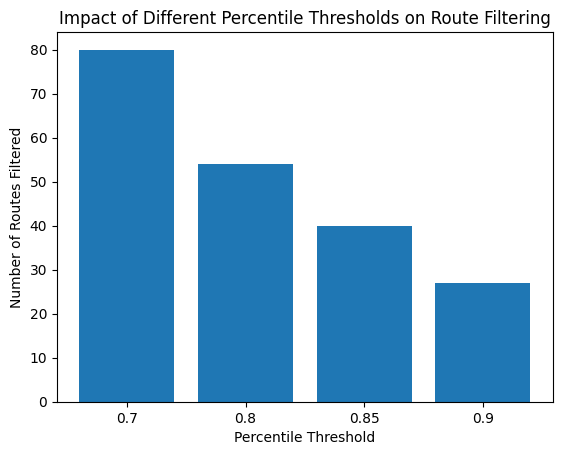

In [ ]:
percentiles_to_test = [0.7, 0.8, 0.85, 0.9]
results = {}

for p in percentiles_to_test:
    threshold_value = int_stn_pv_softmax['Softmax'].quantile(p)
    filtered_threshold = int_stn_pv_softmax[int_stn_pv_softmax['Softmax'] > threshold_value]
    results[p] = len(filtered_threshold)  # or any other metric of interest

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(list(results.items()), columns=['Percentile', 'Count'])
print(results_df)

plt.bar(results_df['Percentile'].astype(str), results_df['Count'])
plt.xlabel('Percentile Threshold')
plt.ylabel('Number of Routes Filtered')
plt.title('Impact of Different Percentile Thresholds on Route Filtering')
plt.show()

In [ ]:
# Set threshold at the 80th percentile of the Softmax values
threshold_value = int_stn_pv_softmax['Softmax'].quantile(0.8)

# Filter for routes with Softmax values above this threshold
filtered_threshold = int_stn_pv_softmax[int_stn_pv_softmax['Softmax'] > threshold_value]
filtered_threshold = filtered_threshold['PT_CODE']

# Merge the filtered bus stops with the bus routes dataframe
merged_threshold_df = pd.merge(bus_routes_df, filtered_threshold, 
                               left_on='BusStopCode', right_on='PT_CODE', 
                               how='inner').drop(columns=['PT_CODE'])

# Group by the service number and count the bus stops
threshold_stop_counts = merged_threshold_df.groupby('ServiceNo')['BusStopCode'].nunique().reset_index()

# Rename the columns for clarity
threshold_stop_counts.columns = ['ServiceNo', 'IntStnLargeDecrease']

# Sort the DataFrame by 'IntStnLargeDecrease' in descending order
threshold_bus_service_sorted = threshold_stop_counts.sort_values(by='IntStnLargeDecrease', ascending=False)
threshold_bus_service_sorted.to_csv('../datasets/pv_eda/threshold_int_stn_bus.csv', index=False)

In [ ]:
#Normalising IntStnLargeDecrease
scaler = MinMaxScaler(feature_range=(0, 1))
threshold_bus_service_sorted['NormalizedIntStnLargeDecrease'] = scaler.fit_transform(
    threshold_bus_service_sorted[['IntStnLargeDecrease']]
)

# Invert the normalized values to penalize higher counts
threshold_bus_service_sorted['InvertedNormalizedIntStnLargeDecrease'] = 1 - threshold_bus_service_sorted['NormalizedIntStnLargeDecrease']

# Apply softmax to the inverted values for further differentiation
max_val = threshold_bus_service_sorted['InvertedNormalizedIntStnLargeDecrease'].max()
threshold_bus_service_sorted['SoftmaxInvertedIntStnLargeDecrease'] = np.exp(
    threshold_bus_service_sorted['InvertedNormalizedIntStnLargeDecrease'] - max_val
) / np.sum(np.exp(threshold_bus_service_sorted['InvertedNormalizedIntStnLargeDecrease'] - max_val))

# Export the results if necessary
threshold_bus_service_sorted.to_csv('../datasets/pv_eda/threshold_int_stn_bus_softmax_inverted.csv', index=False)

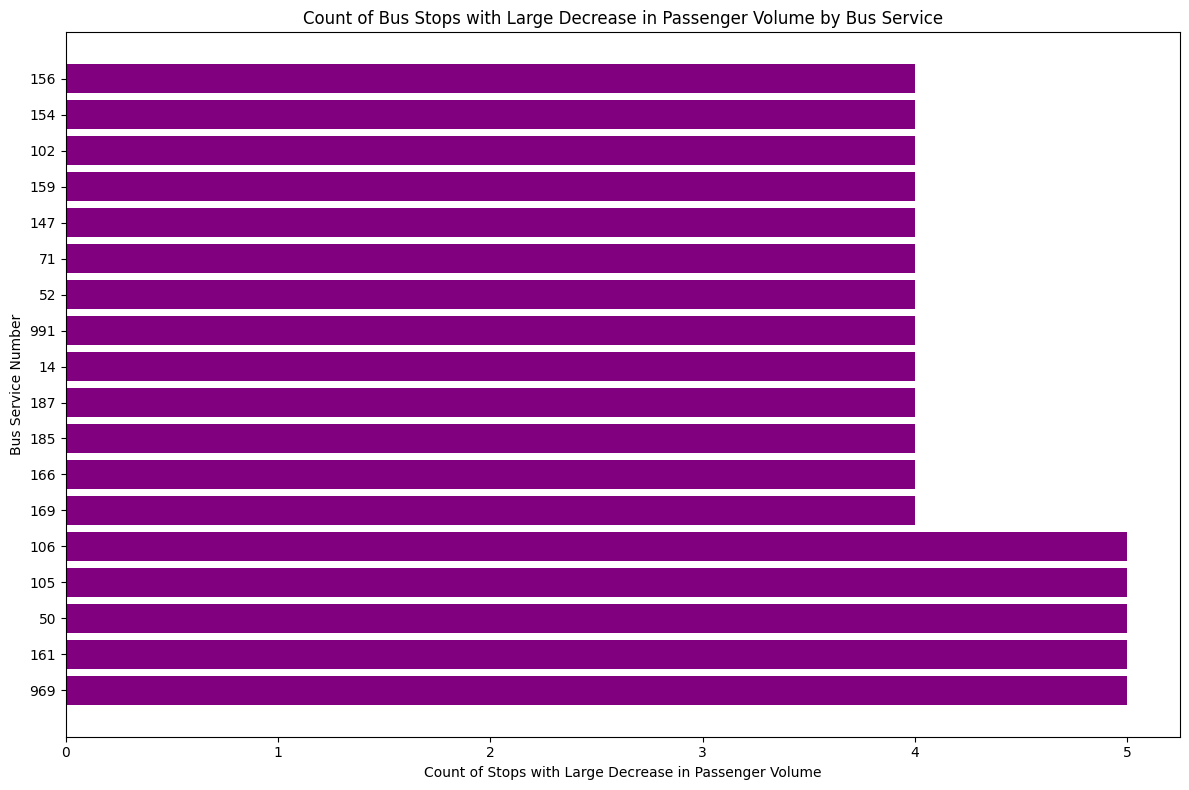

In [ ]:
# Select services that serve at least 3 stations or interchanges with a large decrease
more_than_3_stops = threshold_bus_service_sorted[threshold_bus_service_sorted['IntStnLargeDecrease'] > 3]

# Plot graph
plt.figure(figsize=(12, 8))
plt.barh(more_than_3_stops['ServiceNo'], 
         more_than_3_stops['IntStnLargeDecrease'], 
         color='purple')
plt.xlabel('Count of Stops with Large Decrease in Passenger Volume')
plt.ylabel('Bus Service Number')
plt.title('Count of Bus Stops with Large Decrease in Passenger Volume by Bus Service')
plt.tight_layout()
plt.show()

## EDA of Train Routes and Services

In [ ]:
# Create a new column 'TOTAL_TAP_VOLUME' summing tap-in and tap-out volumes
train_station_jul['TOTAL_TAP_VOLUME'] = train_station_jul['TOTAL_TAP_IN_VOLUME'] + train_station_jul['TOTAL_TAP_OUT_VOLUME']
train_station_aug['TOTAL_TAP_VOLUME'] = train_station_aug['TOTAL_TAP_IN_VOLUME'] + train_station_aug['TOTAL_TAP_OUT_VOLUME']
train_station_sep['TOTAL_TAP_VOLUME'] = train_station_sep['TOTAL_TAP_IN_VOLUME'] + train_station_sep['TOTAL_TAP_OUT_VOLUME']

# Group by PT_CODE and YEAR_MONTH to get total taps for each bus stop per month
train_tap_jul = train_station_jul.groupby(['PT_CODE', 'YEAR_MONTH'])[['TOTAL_TAP_VOLUME']].sum().reset_index()
train_tap_aug = train_station_aug.groupby(['PT_CODE', 'YEAR_MONTH'])[['TOTAL_TAP_VOLUME']].sum().reset_index()
train_tap_sep = train_station_sep.groupby(['PT_CODE', 'YEAR_MONTH'])[['TOTAL_TAP_VOLUME']].sum().reset_index()

In [ ]:
# Concatenate all three months' data
all_months_train_taps = pd.concat([train_tap_jul, 
                             train_tap_aug,
                             train_tap_sep])

# Reset index after concatenation
all_months_train_taps.reset_index(drop=True, inplace=True)
all_months_train_taps.head()

,PT_CODE,YEAR_MONTH,TOTAL_TAP_VOLUME
0,BP1,2024-07,2373441
1,BP10,2024-07,205921
2,BP11,2024-07,210699
3,BP12,2024-07,167576
4,BP13,2024-07,68693
